## Install the logicalinduction package

In [1]:
!pip install logicalinduction

**Important: now click "Restart" from the "Kernel" menu at the top.**

## Import packages

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import logicalinduction as li

## In the code below we will work with these 3 sentences:

In [3]:
sentence1 = li.Atom("socrates is a man")
sentence2 = li.Atom("socrates is mortal")
sentence3 = li.Implication(sentence1, sentence2)

## First we create a helper function that builds trading formulas

This helper returns trading formulas that "buy" whenever the price (credence) for a sentence is below a certain threashold p.

In [4]:
def trade_on_probability(sentence, index, p, slope=10):
    return li.Min(
        li.Constant(1),
        li.Max(
            li.Constant(-1),
            li.Sum(
                li.Constant(slope * p),
                li.Product(
                    li.Constant(-slope),
                    li.Price(sentence1, index)
                )
            )
        )
    )

## Let's plot the quantity traded by this formula as a function of price

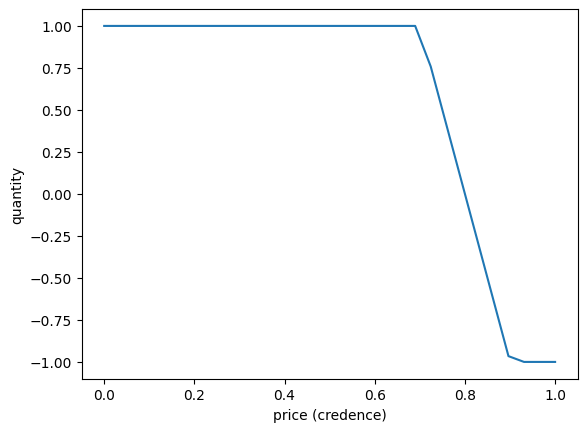

In [5]:
f = trade_on_probability(sentence1, 1, .8)
credences = np.linspace(0, 1, 30)
purchase_quantities = [f.evaluate(li.History([{sentence1: cr}])) for cr in credences]

plt.xlabel('price (credence)')
plt.ylabel('quantity')
plt.plot(credences, purchase_quantities)

As you can see, this trading formula says to purchase 1 token of sentence1 whenever that sentence's price, or credence, is below 0.8, or zero tokens if the price is above 0.8. Actually there is a region just around 0.8 where the quantity move linearly from 1 down to 0 -- this is actually very important.

## Now we define a trading algorithm

A trading algorithm is a generator of trading policies, which are maps from sentences to trading formulas

In [6]:
def trading_alg(sentence, probability):
    count = 1
    while True:
        yield {sentence: trade_on_probability(sentence, count, probability)}
        count += 1

## Create a logical inductor and perform two updates

In [7]:
inductor = li.LogicalInductor()

first_credences = inductor.update(sentence3, trading_alg(sentence3, .5))

print("after first update:")
for sentence, credence in first_credences.items():
    print(f'  credence for "{sentence}"" is {credence}')
    
second_credences = inductor.update(sentence2, trading_alg(sentence3, .5))

print("after second update:")
for sentence, credence in second_credences.items():
    print(f'  credence for "{sentence}"" is {credence}')

third_credences = inductor.update(sentence1, trading_alg(sentence3, .5))

print("after third update:")
for sentence, credence in third_credences.items():
    print(f'  credence for "{sentence}"" is {credence}')

after first update:
  credence for "socrates is a man"" is 0
  credence for "socrates is a man → socrates is mortal"" is 0
after second update:
  credence for "socrates is a man"" is 0
  credence for "socrates is a man → socrates is mortal"" is 1
after third update:
  credence for "socrates is a man"" is 0
  credence for "socrates is a man → socrates is mortal"" is 1


That's it! The rest of this notebook will explore the inner workings of the update function used above.

## Let's look at the inner workings of the logical induction algorithm

First we will get a concrete trading algorithm and pull out the trading policy it uses on the first update.

In [8]:
the_trading_alg = trading_alg(sentence1, .8)

In [9]:
first_trading_policy = next(the_trading_alg)

## Now we solve for our a belief state where this trading policty makes very few trades

We are going to find a set of credences that are not exploited by `first_trading_policy`. The logic for solving for credences is implemented in the library function `li.find_credences`. For this example will use an empty belief history, just as if this was our very first update ever.

In [10]:
history = li.History()   # empty history
credences = li.find_credences(first_trading_policy, history, tolerance=.01)
credences

{socrates is a man: Fraction(4, 5)}

We just solved for our first belief state. This belief state contains only one sentence because our trading policy `first_trading_policy` only trades on one sentence. We can check the quantity traded by our trading policy on the belief state we found:

In [11]:
updated_history = history.with_next_update(credences)
quantity = first_trading_policy[sentence1].evaluate(updated_history)
print('quantity traded is', quantity)

quantity traded is 0.0


In this case our trading policy traded exactly zero, but any quantity less than the tolerance passed to `find_credences` would have been acceptable.

## Plot the space over which `find_credences` searches

To get some insight into how `li.find_credences` works, let us plot the landscape over which it searches. It is looking for a belief state such that the maximum value-of-holdings for the given trading policy is close to zero. 

In [12]:
def value_of_holdings_landscape(trading_policy, credence_history, x_sentence, y_sentence):
    min_possible = np.zeros((20, 20))
    max_possible = np.zeros((20, 20))
    for i, x in enumerate(np.linspace(0, 1, 20)):
        for j, y in enumerate(np.linspace(0, 1, 20)):
            credences = {x_sentence: x, y_sentence: y}
            history = credence_history.with_next_update(credences)

            # check all possible worlds (all possible truth values for the support sentences)
            possible_values = []
            for truth_values in itertools.product([0, 1], repeat=2):
                world = {sentence1: truth_values[0], sentence2: truth_values[1]}
                value_of_holdings = li.evaluate(trading_policy, history, world)
                possible_values.append(value_of_holdings)
                
            min_possible[j,i] = min(possible_values)
            max_possible[j,i] = max(possible_values)

    return min_possible, max_possible

_, max_landscape = value_of_holdings_landscape(first_trading_policy, history, sentence1, sentence2)

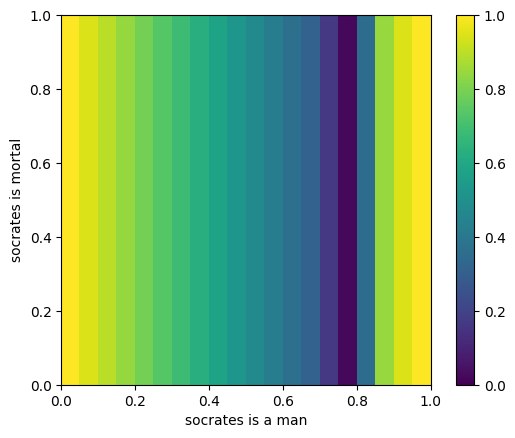

In [13]:
plt.imshow(max_landscape, extent=(0, 1, 0, 1), vmin=0, vmax=1)
plt.xlabel(sentence1)
plt.ylabel(sentence2)
plt.colorbar()
plt.show()

So we can see that this function has a local minimum when the credences for "socrates is a man" is 0.8, and as expected this function does not depend at all on the credence for "socrates is mortal"

## Compute a budget factor

To demonstrate the inner workings of the logical induction algorith, let's look at the structure of a budget factor. Here is the formula from our one-sentence trading policy as a syntax tree:

In [14]:
print(first_trading_policy[sentence1].tree())

Min
. Constant(1)
. Max
. . Constant(-1)
. . Sum
. . . Constant(8.0)
. . . Product
. . . . Constant(-10)
. . . . Price(socrates is a man, 1)


Now let's compute a budget factor and print it as a syntax tree.

In [15]:
budget_factor = li.compute_budget_factor(
    budget=2,
    observation_history=[],
    next_observation=sentence1,
    trading_history=[],
    next_trading_formulas=first_trading_policy,
    credence_history=history)

print(budget_factor.tree())

SafeReciprocal
. Max
. . Product
. . . Constant(0.5)
. . . Product
. . . . Constant(-1)
. . . . Sum
. . . . . Product
. . . . . . Min
. . . . . . . Constant(1)
. . . . . . . Max
. . . . . . . . Constant(-1)
. . . . . . . . Sum
. . . . . . . . . Constant(8.0)
. . . . . . . . . Product
. . . . . . . . . . Constant(-10)
. . . . . . . . . . Price(socrates is a man, 1)
. . . . . . Sum
. . . . . . . Constant(1.0)
. . . . . . . Product
. . . . . . . . Constant(-1)
. . . . . . . . Price(socrates is a man, 1)
